In [41]:
## Updated 1-7-25


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from joblib import dump
import time
import unsupervised_scripts


### TRAIN MODEL

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(input('Enter HSI step size: ').strip()) 
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')
shift = 15

## Training Directory (different for everyone)
path_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
data_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
sample_dir = data_dir + 'training_data/'+str(num_samp)+'/'

artificial_dataset = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df, shift)
[image_vec, _, _,_] = artificial_dataset.save_srs_params(sample_dir)
[mol_norm, mol_names] = artificial_dataset.molecule_dataset(molecule_df)

## Load artificial dataset
X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_norm = preprocessing.spectral_standardization(image_vec, br_shift=0)

100%|██████████| 4/4 [00:00<00:00, 10.41it/s]


(array([ 6050., 20520., 30060., 22470., 18960., 15400., 10000.,  4750.,
         1310.,   480.]),
 array([0.        , 0.11254491, 0.22508982, 0.33763473, 0.45017963,
        0.56272454, 0.67526945, 0.78781436, 0.90035927, 1.01290418,
        1.12544909]),
 <BarContainer object of 10 artists>)

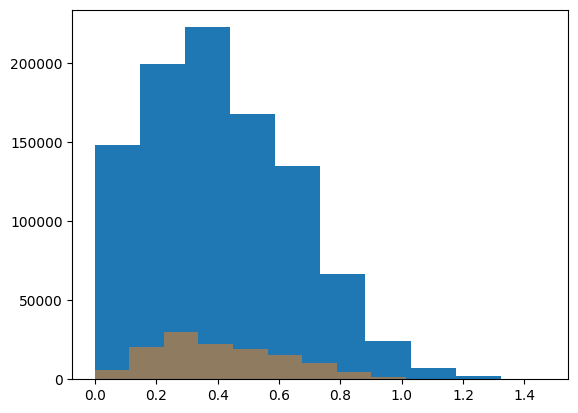

In [43]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0])
plt.hist(np.max(X_norm, axis=1)-X_norm[:,0],alpha=0.5)

Text(0, 0.5, 'Normalized Intensity (A.U.)')

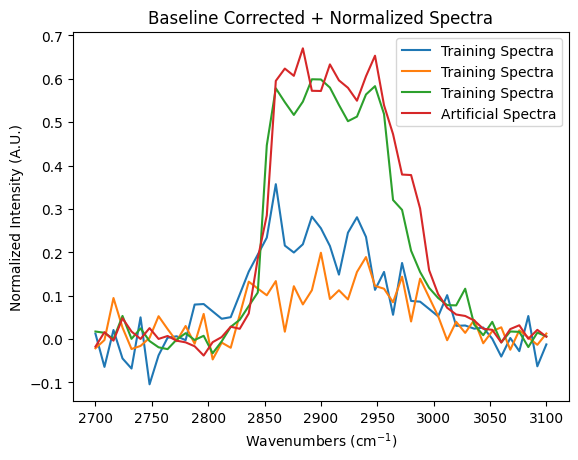

In [44]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [45]:
# ## Optimize Smoothing of HSI and artificial spectra
# w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
# p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
# preprocessing.sav_gol_optimization(image_norm, w, p)
# preprocessing.sav_gol_optimization(X_norm, w, p)
# x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
# X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')
# smooth = 'smoothing-'+str(w)+'-'+str(p)

In [46]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm
smooth = 'No Smoothing'

In [47]:
## Train Random Forest Classifier
start_time = time.time()
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
rfc = rf_classifier.train(num_estimators=350)
dump(rfc, 'rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.joblib')
end_time = time.time()
execution_time = end_time - start_time
print(f" Training Finished \n Execution time: {execution_time} seconds")

 Training Finished 
 Execution time: 192.84298968315125 seconds
